# Topic: **Traffic Density Detection**
### Course: **Artificial Intelligence IT159IU**

<ol type="1">
  <li>Tran The Phong - ITCSIU21215</li>
  <li>Nguyen Binh Phuong Huy - ITCSIU21189</li>
  <li>Do Gia Thuy - ITCSIU21237</li>
</ol>

In [ ]:
! pip install kaggle

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 63 bytes


In [ ]:
!kaggle datasets download "rahat52/traffic-density-singapore"

Dataset URL: https://www.kaggle.com/datasets/rahat52/traffic-density-singapore
License(s): GNU Free Documentation License 1.3
 99% 219M/222M [00:02<00:00, 106MB/s]
100% 222M/222M [00:02<00:00, 94.7MB/s]


In [ ]:
!unzip traffic-density-singapore.zip

Archive:  traffic-density-singapore.zip
  inflating: Final Dataset/testing/Empty/00a2d16e-742e-469f-a23a-631ad49ec790.jpg  
  inflating: Final Dataset/testing/Empty/01d0f221-a94d-44ce-ba07-462f2f46f62c.jpg  
  inflating: Final Dataset/testing/Empty/02bbbe52-297c-4eed-aac2-de40ad6bd0b8.jpg  
  inflating: Final Dataset/testing/Empty/0a175e12-bade-49c4-ad00-c07329ce5fd4.jpg  
  inflating: Final Dataset/testing/Empty/0a37454f-40c2-4302-9e8b-23af7b95875b.jpg  
  inflating: Final Dataset/testing/Empty/0a7b874b-20dd-4ab2-b2ed-89645e4c20bc.jpg  
  inflating: Final Dataset/testing/Empty/0a86cfa7-7b99-4ce7-8da8-42c51d2eafff.jpg  
  inflating: Final Dataset/testing/Empty/0aad5c2c-a166-416a-9d6d-3e5da232a5ae.jpg  
  inflating: Final Dataset/testing/Empty/0acd3ef9-fa98-4e37-aca9-58e4848e36fd.jpg  
  inflating: Final Dataset/testing/Empty/0b6dc85e-a9ba-4d74-8682-d4dd58587bef.jpg  
  inflating: Final Dataset/testing/Empty/0ba3c8b2-04e2-401e-bb05-9f70e1740168.jpg  
  inflating: Final Dataset/testing/E

## Data Loading and Processing

In [ ]:
# Part 1: Data Loading and Processing
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
from google.colab import drive
# drive.mount('/content/drive')

train_dir = "/content/Final Dataset/training"
val_dir = "/content/Final Dataset/validation"
test_dir = "/content/Final Dataset/testing"

# No random flip, rotation, or random crop: just resize + normalization
common_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])
])

train_ds = ImageFolder(root=train_dir, transform=common_transform)
val_ds   = ImageFolder(root=val_dir,   transform=common_transform)
test_ds  = ImageFolder(root=test_dir,  transform=common_transform)

classes = train_ds.classes
print("Classes:", classes)

batch_size = 32

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  num_workers=4)
val_dl   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=4)
test_dl  = DataLoader(test_ds,  batch_size=batch_size, shuffle=True,  num_workers=4)


Classes: ['Empty', 'High', 'Low', 'Medium', 'Traffic Jam']


## Define CNN model

In [ ]:
# Part 2: Define CNN model
class TrafficDensityCNN(nn.Module):
    def __init__(self, num_classes):
        super(TrafficDensityCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.bn1   = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2   = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3   = nn.BatchNorm2d(128)
        self.pool  = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1   = nn.Linear(128 * 16 * 16, 256)
        self.fc2   = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

num_classes = len(classes)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TrafficDensityCNN(num_classes).to(device)

In [ ]:
# check model summary
! pip install torchsummary
from torchsummary import summary
summary(model, input_size=(3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
       BatchNorm2d-2         [-1, 32, 128, 128]              64
         MaxPool2d-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 64, 64, 64]          18,496
       BatchNorm2d-5           [-1, 64, 64, 64]             128
         MaxPool2d-6           [-1, 64, 32, 32]               0
            Conv2d-7          [-1, 128, 32, 32]          73,856
       BatchNorm2d-8          [-1, 128, 32, 32]             256
         MaxPool2d-9          [-1, 128, 16, 16]               0
           Linear-10                  [-1, 256]       8,388,864
           Linear-11                    [-1, 5]           1,285
Total params: 8,483,845
Trainable params: 8,483,845
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.19
Forw

In [ ]:
pip install torchviz

In [ ]:
from torchviz import make_dot

sample_input = torch.randn(1, 3, 128, 128).to(device)

output = model(sample_input)

dot = make_dot(output, params=dict(model.named_parameters()))
dot.render("model_graph", format="png")

'model_graph.png'

In [ ]:
# Early Stopping
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0):
        """
        patience:  how many epochs to wait before stopping if no improvement
        delta:     minimum change in monitored quantity to qualify as improvement
        """
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.best_val_acc = 0.0

    def __call__(self, val_acc, model, path):
        score = val_acc
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_acc, model, path)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_acc, model, path)
            self.counter = 0

    def save_checkpoint(self, val_acc, model, path):
        if self.verbose:
            print(f"Validation accuracy increased ({self.best_val_acc:.4f} --> {val_acc:.4f}). Saving model...")
        torch.save(model.state_dict(), path)
        self.best_val_acc = val_acc

early_stopper = EarlyStopping(patience=50, verbose=True)

## Training and Validation

In [ ]:
# Part 3: Training and Validation with Data Augmentation for Imbalanced Dataset and Saving the Best Model

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# If you want a learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5,
                                                patience=3, verbose=True)

best_val_accuracy = 0.0
best_model_path = 'best_traffic_density_cnn.pth'

train_acc_history = []
val_acc_history   = []
train_loss_history = []
val_loss_history   = []

epochs = 1000
for epoch in range(epochs):
    model.train()
    train_loss    = 0.0
    train_correct = 0

    for imgs, labels in train_dl:
        imgs, labels = imgs.to(device), labels.to(device)

        outputs = model(imgs)
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * imgs.size(0)
        train_correct += (outputs.argmax(1) == labels).sum().item()

    train_accuracy = train_correct / len(train_ds)
    avg_train_loss = train_loss / len(train_ds)
    train_acc_history.append(train_accuracy)
    train_loss_history.append(avg_train_loss)

    # Validation
    model.eval()
    val_loss, val_correct = 0.0, 0
    with torch.no_grad():
        for imgs, labels in val_dl:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)

            val_loss += loss.item() * imgs.size(0)
            val_correct += (outputs.argmax(1) == labels).sum().item()

    val_accuracy = val_correct / len(val_ds)
    avg_val_loss = val_loss / len(val_ds)
    val_acc_history.append(val_accuracy)
    val_loss_history.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{epochs}")
    print(f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.4f}")
    print(f"Val Loss:   {avg_val_loss:.4f},   Val Acc:   {val_accuracy:.4f}")

    scheduler.step(val_accuracy)
    early_stopper(val_accuracy, model, best_model_path)

    if early_stopper.early_stop:
        print("Early stopping triggered. No improvement in validation accuracy.")
        break

    # Save the best model
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), best_model_path)
        print(f"Best model saved with Val Acc: {best_val_accuracy:.4f}")

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 1/1000
Train Loss: 1.9498, Train Acc: 0.5888
Val Loss:   0.6144,   Val Acc:   0.7529
Validation accuracy increased (0.0000 --> 0.7529). Saving model...
Best model saved with Val Acc: 0.7529
Epoch 2/1000
Train Loss: 0.7070, Train Acc: 0.7232
Val Loss:   0.7134,   Val Acc:   0.7294
EarlyStopping counter: 1 out of 50
Epoch 3/1000
Train Loss: 0.6109, Train Acc: 0.7519
Val Loss:   0.5735,   Val Acc:   0.7529
Validation accuracy increased (0.7529 --> 0.7529). Saving model...
Epoch 4/1000
Train Loss: 0.5111, Train Acc: 0.7880
Val Loss:   0.4717,   Val Acc:   0.8206
Validation accuracy increased (0.7529 --> 0.8206). Saving model...
Best model saved with Val Acc: 0.8206
Epoch 5/1000
Train Loss: 0.4938, Train Acc: 0.7940
Val Loss:   0.4973,   Val Acc:   0.7941
EarlyStopping counter: 1 out of 50
Epoch 6/1000
Train Loss: 0.4641, Train Acc: 0.8114
Val Loss:   0.4720,   Val Acc:   0.7971
EarlyStopping counter: 2 out of 50
Epoch 7/1000
Train Loss: 0.4317, Train Acc: 0.8265
Val Loss:   0.4784,  

## Plot the result

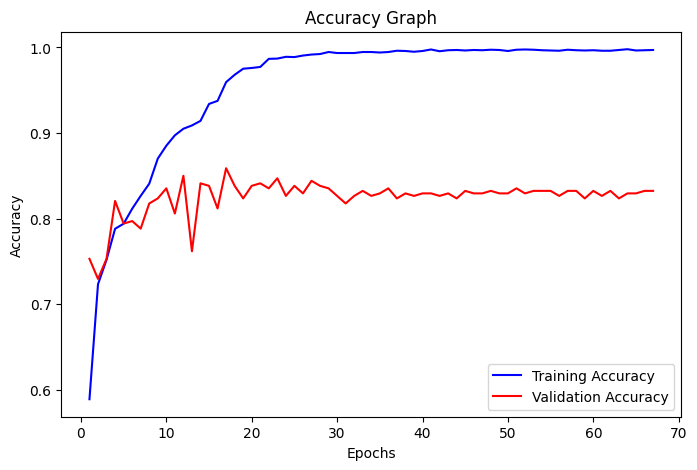

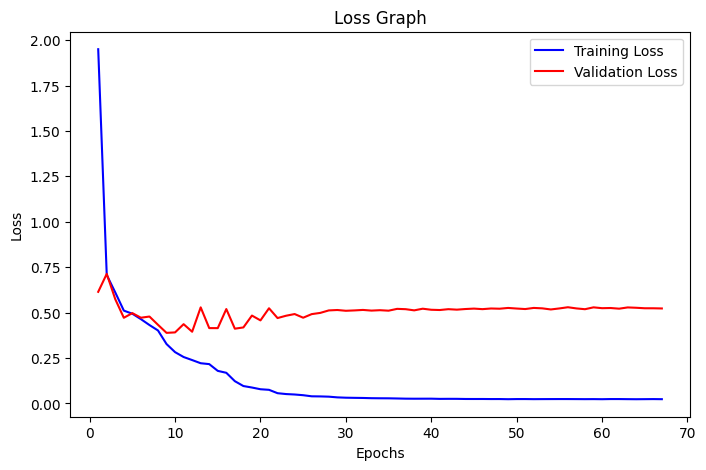

In [ ]:
# Part 4: Plot the result

import matplotlib.pyplot as plt

epochs_range = range(1, len(train_acc_history) + 1)

# Accuracy Graph
plt.figure(figsize=(8,5))
plt.plot(epochs_range, train_acc_history, 'b', label='Training Accuracy')
plt.plot(epochs_range, val_acc_history,   'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss Graph
plt.figure(figsize=(8,5))
plt.plot(epochs_range, train_loss_history, 'b', label='Training Loss')
plt.plot(epochs_range, val_loss_history,   'r', label='Validation Loss')
plt.title('Loss Graph')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Testing the Best Model

In [ ]:
# Part 5: Testing the Best Model

model = TrafficDensityCNN(num_classes)
model.load_state_dict(torch.load(best_model_path))
model.to(device)
model.eval()

test_correct = 0
with torch.no_grad():
    for imgs, labels in test_dl:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        test_correct += (outputs.argmax(1) == labels).sum().item()

test_accuracy = test_correct / len(test_ds)
print(f"Test Accuracy: {test_accuracy:.4f}")

<ipython-input-15-f44c2961a9d6>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


Test Accuracy: 0.8562


In [ ]:
# Reload the model
model = TrafficDensityCNN(num_classes)
model.load_state_dict(torch.load("/content/best_traffic_density_cnn.pth"))
model.to(device)
model.eval()

<ipython-input-41-34b253b9c45e>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/content/best_traffic_density_cnn.pth"))


TrafficDensityCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=32768, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=5, bias=True)
)

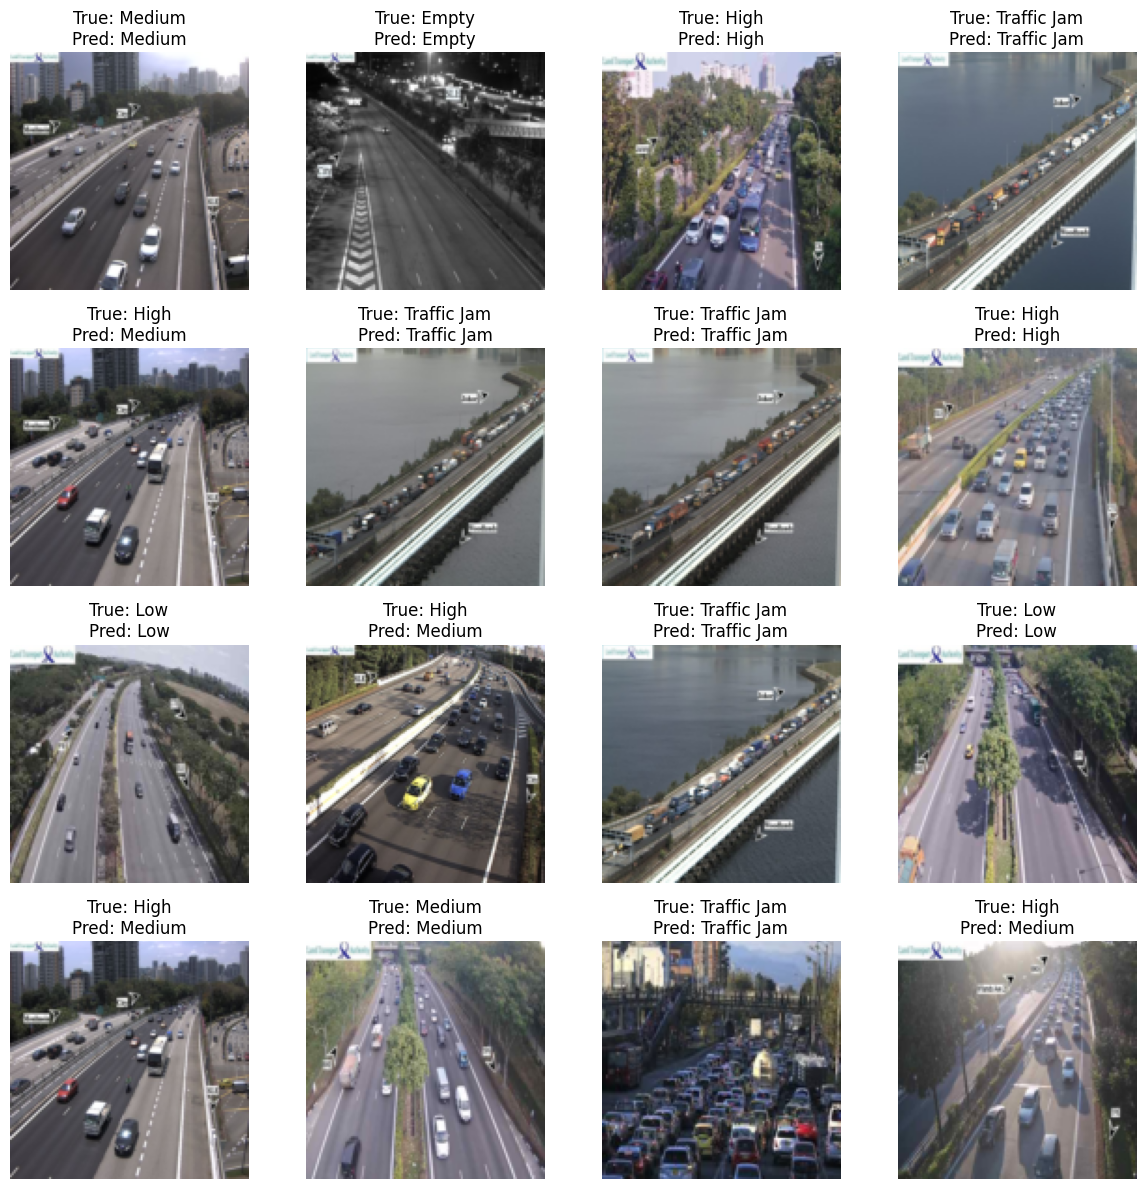

In [ ]:
import numpy as np

model.eval()
imgs, labels = next(iter(test_dl))
imgs = imgs.to(device)
outputs = model(imgs)
preds = outputs.argmax(1)

fig, axes = plt.subplots(4, 4, figsize=(12, 12))
axes = axes.flatten()

num_images = min(len(imgs), 16)
for i in range(num_images):
    img = imgs[i].permute(1, 2, 0).cpu().numpy()
    # denormalize: img * std + mean
    img = img * 0.5 + 0.5
    label = classes[labels[i].item()]
    pred = classes[preds[i].item()]
    axes[i].imshow(img)
    axes[i].set_title(f"True: {label}\nPred: {pred}")
    axes[i].axis("off")

for i in range(num_images, 16):
    axes[i].axis("off")

plt.tight_layout()
plt.show()